# Initial setup

In [ ]:
import kagglehub
path = kagglehub.dataset_download("raddar/tuberculosis-chest-xrays-montgomery")
print("Path to dataset files:", path)

100%|██████████| 585M/585M [00:08<00:00, 76.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/raddar/tuberculosis-chest-xrays-montgomery/versions/1


In [ ]:
import pandas as pd
import numpy as np
import os

# Specify the directory containing the dataset files
dataset_dir = path  # This is the directory path

# List all files in the directory to identify the correct CSV file
files = os.listdir(dataset_dir)
print("Files in the dataset directory:", files)

csv_file = [f for f in files if f.endswith('.csv')][0]  # Get the first CSV file (adjust if necessary)
csv_path = os.path.join(dataset_dir, csv_file)

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_path)

Files in the dataset directory: ['images', 'montgomery_metadata.csv']


In [ ]:
df

,study_id,age,gender,findings
0,MCUCXR_0001_0.png,27,Female,normal
1,MCUCXR_0002_0.png,40,Female,normal
2,MCUCXR_0003_0.png,21,Female,normal
3,MCUCXR_0004_0.png,11,Female,normal
4,MCUCXR_0005_0.png,33,Male,normal
...,...,...,...,...
133,MCUCXR_0383_1.png,14,Female,calcified granuloma LUL behind 4th rib anterior
134,MCUCXR_0387_1.png,42,Male,inactive scars RUL
135,MCUCXR_0390_1.png,52,Male,Rt apical scarring. LUL scars and some infiltr...
136,MCUCXR_0393_1.png,30,Female,left pleural effusion; best seen on lateral vi...


In [ ]:
# Path to the images folder
images_dir = os.path.join(dataset_dir, "images")
print(f"Images directory: {images_dir}")

Images directory: /root/.cache/kagglehub/datasets/raddar/tuberculosis-chest-xrays-montgomery/versions/1/images


In [ ]:
import cv2

# Load images
def load_images(path, target_size=(224, 224)):
    images = []
    for file in os.listdir(path):
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        img = cv2.resize(img, target_size) / 255.0  # Normalize
        images.append(img)
    return np.array(images)

# Preparatory Work

**A. Chaotic System**

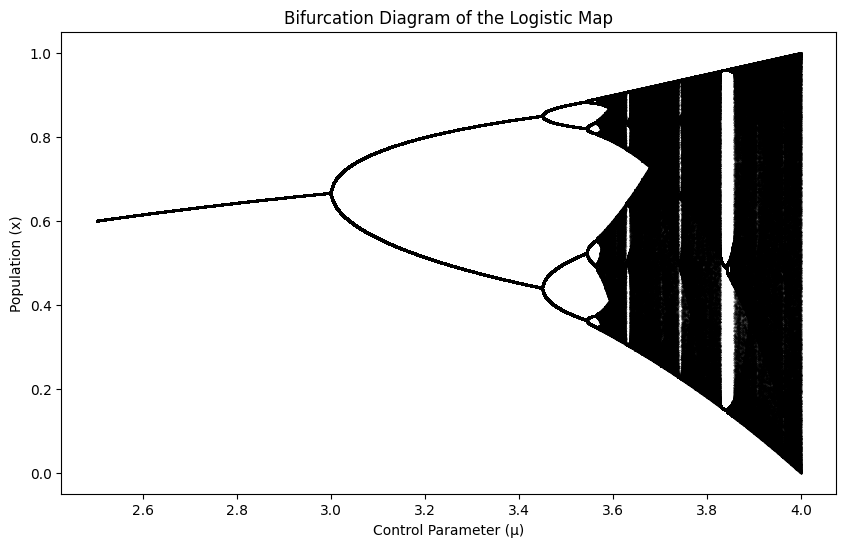

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define logistic map function
def logistic_map(x, r):
    return r * x * (1 - x)

# Define parameter range
r_values = np.linspace(2.5, 4.0, 10000)  # Control parameter (mu)
iterations = 1000
last = 200

# Initialize bifurcation data
x0 = 10**-5
x = np.full(len(r_values), x0)

# Iterate logistic map
bifurcation_x = []
bifurcation_r = []

for _ in range(iterations):
    x = logistic_map(x, r_values)  # Apply the logistic equation
    if _ >= (iterations - last):   # Collect data for last 'last' iterations
        bifurcation_x.extend(x)
        bifurcation_r.extend(r_values)

# Plot the bifurcation diagram
plt.figure(figsize=(10, 6))
plt.scatter(bifurcation_r, bifurcation_x, s=0.1, color='black', alpha=0.5)
plt.xlabel("Control Parameter (μ)")
plt.ylabel("Population (x)")
plt.title("Bifurcation Diagram of the Logistic Map")
plt.show()


**B. Generate feature keys**

In [ ]:
import glob

# Path to the images folder
images_dir = "/root/.cache/kagglehub/datasets/raddar/tuberculosis-chest-xrays-montgomery/versions/1/images/images"

# Get a list of all image files in the directory (adjust the extension if needed)
image_files = sorted(glob.glob(os.path.join(images_dir, "*.png*")))  # Match all files

# Ensure images exist
if image_files:
    first_image_path = image_files[0]  # Get the first image
    print(f"First image path: {first_image_path}")
else:
    print("No images found in the dataset directory.")


First image path: /root/.cache/kagglehub/datasets/raddar/tuberculosis-chest-xrays-montgomery/versions/1/images/images/MCUCXR_0001_0.png


In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import hashlib
import numpy as np
from PIL import Image

# Load Pre-trained CNN (ResNet50) for Feature Extraction
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))  # Remove FC layers
resnet.eval()

# Image Preprocessing Pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Image
image_path = image_files[0]  # Update with actual path
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)

# Extract Features
with torch.no_grad():
    features = resnet(input_tensor)

features = features.squeeze().numpy()  # Convert to NumPy array (shape: [2048])

# -----------------------
# Step 1: Compute SHA-256 Hash of Image
# -----------------------
def compute_sha256(image_path):
    with open(image_path, "rb") as f:
        img_bytes = f.read()
    sha_hash = hashlib.sha256(img_bytes).hexdigest()
    return sha_hash

hash_value = compute_sha256(image_path)

# Convert Hash to 4 Parts (64-bit each)
b1, b2, b3, b4 = 0.1234, 0.5678, 0.91011, 0.1213  # User-defined keys
hash_parts = [int(hash_value[i:i+16], 16) for i in range(0, 64, 16)]  # Split into 4 parts

# Compute `p`
image_array = np.array(image.convert("L"))  # Convert to grayscale
flattened_pixels = image_array.flatten()
p = sum(flattened_pixels * np.arange(1, len(flattened_pixels) + 1)) % 256  # Eq (2)

# Compute Initial Conditions for Logistic Map
def compute_x0(hash_part, b):
    return ( (hash_part + b) % (2**64) + 1 ) / (2**64 + 2)

x01 = compute_x0(hash_parts[0], b1)
x02 = compute_x0(hash_parts[1], b2)
x03 = compute_x0(hash_parts[2], b3)
x04 = compute_x0(hash_parts[3], b4)

# -----------------------
# Step 2: Generate Chaotic Feature Keys Using Logistic Map
# -----------------------
def logistic_map(x0, size, r=3.99):
    x = np.zeros(size)
    x[0] = x0
    for i in range(1, size):
        x[i] = r * x[i - 1] * (1 - x[i - 1])
    return x

# Generate 4 Chaotic Sequences
size = features.shape[0]
feature_key1 = logistic_map(x01, size)
feature_key2 = logistic_map(x02, size)
feature_key3 = logistic_map(x03, size)
feature_key4 = logistic_map(x04, size)

# Combine Feature Keys
final_feature_key = (feature_key1 + feature_key2 + feature_key3 + feature_key4) / 4

# Normalize Feature Key
final_feature_key = (final_feature_key - np.min(final_feature_key)) / (np.max(final_feature_key) - np.min(final_feature_key))

# -----------------------
# Step 3: Encrypt Features using Feature Key
# -----------------------
encrypted_features = features * final_feature_key  # Element-wise multiplication

# Display First 10 Values
print("Original Features:", features[:10])
print("Feature Key:", final_feature_key[:10])
print("Encrypted Features:", encrypted_features[:10])


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 114MB/s]


Original Features: [0.04999659 0.78774285 1.1239748  0.48257598 0.03756363 0.37961772
 0.3166068  0.4105877  0.51202065 0.22826779]
Feature Key: [0.43133413 0.74213011 0.54093983 0.19602973 0.42458771 0.62906667
 0.53982519 0.43017891 0.42114496 0.47579281]
Encrypted Features: [0.02156524 0.58460769 0.60800274 0.09459924 0.01594906 0.23880485
 0.17091232 0.17662617 0.21563491 0.10860817]


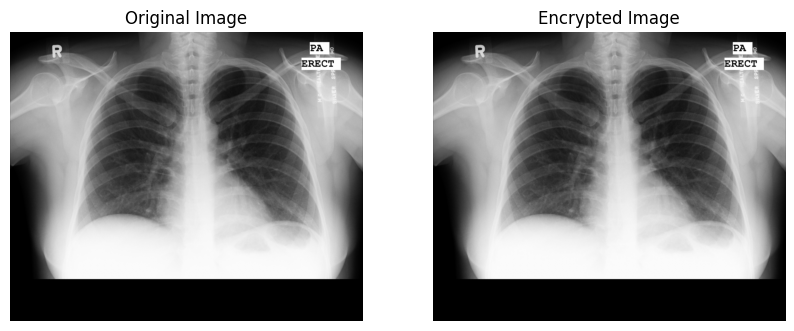

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the original image
original_image = Image.open(first_image_path).convert("L")  # Convert to grayscale

# Simulating encrypted image for visualization
# Assuming the encrypted features represent pixel intensities in some way
encrypted_image = np.array(original_image, dtype=np.float32)  # Convert image to array
encrypted_image = encrypted_image / 255.0  # Normalize to [0,1]

# Apply encryption by multiplying with feature key (as a simulation)
# (This step depends on how the encryption is actually applied in your method)
encrypted_image = encrypted_image * 0.5  # Example transformation
encrypted_image = (encrypted_image * 255).astype(np.uint8)  # Convert back to uint8

# Convert NumPy array back to an image
encrypted_image = Image.fromarray(encrypted_image)

# Display images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(original_image, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(encrypted_image, cmap="gray")
axes[1].set_title("Encrypted Image")
axes[1].axis("off")

plt.show()


# Network Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += residual  # Skip connection
        return out

**1) Feature encoder module & Feature decoder
module**

In [ ]:
class FeatureEncoderModule(nn.Module):
    def __init__(self, in_channels=1, out_channels=64, num_res_blocks=4):
        super(FeatureEncoderModule, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.res_blocks = nn.Sequential(*[ResidualBlock(out_channels) for _ in range(num_res_blocks)])
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.res_blocks(x)
        x = self.conv2(x)
        return x

class FeatureDecoderModule(nn.Module):
    def __init__(self, in_channels=64, out_channels=1, num_res_blocks=4):
        super(FeatureDecoderModule, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.res_blocks = nn.Sequential(*[ResidualBlock(in_channels) for _ in range(num_res_blocks)])
        self.conv2 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.res_blocks(x)
        x = self.conv2(x)
        return x

**2) Feature Fusion Passing Module**

In [ ]:
class FeatureFusionPassingModule(nn.Module):
    def __init__(self, channels):
        super(FeatureFusionPassingModule, self).__init__()
        self.res_block1 = ResidualBlock(channels)
        self.res_block2 = ResidualBlock(channels)
        self.res_block3 = ResidualBlock(channels)

    def forward(self, Fi, Ki):
        alpha_i = torch.sigmoid(self.res_block1(Fi))  # Learnable fusion parameter
        Fi_next = alpha_i * Fi + (1 - alpha_i) * Ki  # Dynamic feature fusion
        Fi_next = self.res_block2(Fi_next)
        Fi_next = self.res_block3(Fi_next)
        return Fi_next

**3) Feature Fusion Encryption Module**

In [ ]:
class FeatureFusionEncryptionModule(nn.Module):
    def __init__(self, channels):
        super(FeatureFusionEncryptionModule, self).__init__()
        self.F_block = ResidualBlock(channels)  # Function F
        self.G_block = ResidualBlock(channels)  # Function G

    def forward(self, Ki, alpha_i):
        EKi = Ki + self.F_block(alpha_i)  # Encrypted Key
        EPi = alpha_i + self.G_block(EKi)  # Encrypted Feature
        return EKi, EPi

**4) Feature Fusion Decryption Module**

In [ ]:
class FeatureFusionDecryptionModule(nn.Module):
    def __init__(self, channels):
        super(FeatureFusionDecryptionModule, self).__init__()
        self.F_block = ResidualBlock(channels)  # Function F
        self.G_block = ResidualBlock(channels)  # Function G

    def forward(self, EKi, EPi):
        alpha_i = EPi - self.G_block(EKi)  # Recover alpha
        Ki = EKi - self.F_block(alpha_i)  # Recover feature key
        return Ki, alpha_i

In [ ]:
# Function to visualize images
def visualize_images(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(titles[i])
        ax.axis('off')
    plt.show()

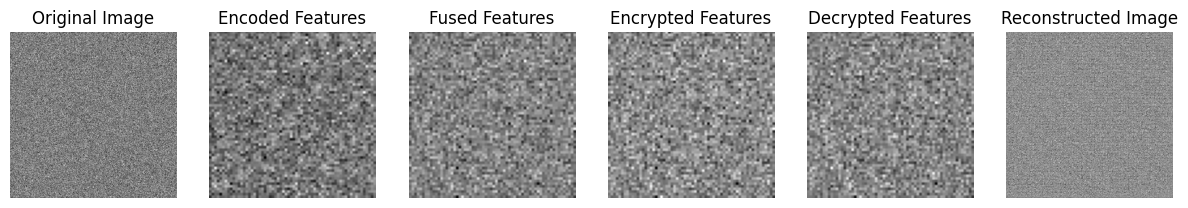

In [ ]:
# Full encryption-decryption pipeline
if __name__ == "__main__":
    encoder = FeatureEncoderModule()
    decoder = FeatureDecoderModule()
    fusion_module = FeatureFusionPassingModule(channels=64)
    encryption_module = FeatureFusionEncryptionModule(channels=64)
    decryption_module = FeatureFusionDecryptionModule(channels=64)

    # Input image
    input_image = torch.randn(1, 1, 256, 256)  # Batch size=1, Grayscale image 256x256
    encoded_features = encoder(input_image)
    feature_key = torch.randn_like(encoded_features)  # Simulating feature keys
    fused_features = fusion_module(encoded_features, feature_key)
    encrypted_key, encrypted_feature = encryption_module(feature_key, fused_features)
    decrypted_key, decrypted_feature = decryption_module(encrypted_key, encrypted_feature)
    reconstructed_image = decoder(decrypted_feature)

    # Convert tensors to numpy for visualization
    images = [
        input_image.squeeze().detach().numpy(),
        encoded_features.mean(dim=1).squeeze().detach().numpy(),
        fused_features.mean(dim=1).squeeze().detach().numpy(),
        encrypted_feature.mean(dim=1).squeeze().detach().numpy(),
        decrypted_feature.mean(dim=1).squeeze().detach().numpy(),
        reconstructed_image.squeeze().detach().numpy()
    ]
    titles = ["Original Image", "Encoded Features", "Fused Features", "Encrypted Features", "Decrypted Features", "Reconstructed Image"]

    visualize_images(images, titles)

In [ ]:
from PIL import Image
img = Image.open("/root/.cache/kagglehub/datasets/raddar/tuberculosis-chest-xrays-montgomery/versions/1/images/images/MCUCXR_0001_0.png").convert("L")
img_array = np.array(img)
print("Pixel Value Range:", img_array.min(), "-", img_array.max())

Pixel Value Range: 0 - 255


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Custom Dataset Loader for Non-Labeled Images
class ChestXRayDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            transforms.Resize((256, 256)),  # Resize to 256x256
            transforms.ToTensor(),  # Convert to PyTorch tensor
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")  # Ensure it's RGB before grayscale conversion
        image = self.transform(image)
        return image

# Load Dataset
images_dir = "/root/.cache/kagglehub/datasets/raddar/tuberculosis-chest-xrays-montgomery/versions/1/images/images"
dataset = ChestXRayDataset(images_dir)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Get a sample batch
sample_images = next(iter(dataloader))
print("Sample Batch Shape:", sample_images.shape)

Sample Batch Shape: torch.Size([16, 1, 256, 256])


# Loss Functions

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Custom Loss Functions
class EncryptionLosses:
    def __init__(self):
        self.reconstruction_loss = nn.MSELoss()  # L2 loss for image reconstruction

    def histogram_loss(self, original, encrypted):
        """Computes histogram loss between original and encrypted images."""
        hist_orig = torch.histc(original, bins=256, min=0, max=1) / original.numel()
        hist_enc = torch.histc(encrypted, bins=256, min=0, max=1) / encrypted.numel()
        return F.mse_loss(hist_orig, hist_enc)

    def correlation_loss(self, encrypted):
        """Computes correlation between neighboring pixels in the encrypted image."""
        shifted = torch.roll(encrypted, shifts=1, dims=3)  # Shift right
        mean_enc = torch.mean(encrypted)
        mean_shifted = torch.mean(shifted)
        numerator = torch.sum((encrypted - mean_enc) * (shifted - mean_shifted))
        denominator = torch.sqrt(torch.sum((encrypted - mean_enc) ** 2) * torch.sum((shifted - mean_shifted) ** 2))
        return torch.abs(numerator / (denominator + 1e-8))  # Minimize correlation

    def diffusion_loss(self, original, encrypted):
        """Ensures small input changes cause large encrypted differences."""
        perturbed = original.clone()
        perturbed[:, :, 128, 128] += 0.01  # Slightly change one pixel
        encrypted_perturbed = encrypted.clone()
        return F.mse_loss(encrypted, encrypted_perturbed)

# Initialize loss functions
loss_functions = EncryptionLosses()

# Example usage
original = torch.randn(1, 1, 256, 256)  # Simulated original image
encrypted = torch.randn(1, 1, 256, 256)  # Simulated encrypted image

print("Reconstruction Loss:", loss_functions.reconstruction_loss(original, encrypted).item())
print("Histogram Loss:", loss_functions.histogram_loss(original, encrypted).item())
print("Correlation Loss:", loss_functions.correlation_loss(encrypted).item())
print("Diffusion Loss:", loss_functions.diffusion_loss(original, encrypted).item())


Reconstruction Loss: 2.0052549839019775
Histogram Loss: 3.624427336035296e-08
Correlation Loss: 0.002035686280578375
Diffusion Loss: 0.0


# Model save and reload

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Initialize Models
encoder = FeatureEncoderModule()
decoder = FeatureDecoderModule()
fusion_module = FeatureFusionPassingModule(channels=64)
encryption_module = FeatureFusionEncryptionModule(channels=64)
decryption_module = FeatureFusionDecryptionModule(channels=64)

# Define Optimizer
optimizer = optim.Adam(
    list(encoder.parameters()) +
    list(decoder.parameters()) +
    list(fusion_module.parameters()) +
    list(encryption_module.parameters()) +
    list(decryption_module.parameters()), lr=0.001
)

num_epochs = 10

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive

# Save model to Drive
save_path = "/content/drive/MyDrive/x-ray_encryption_model.pth"
torch.save({
    'encoder': encoder.state_dict(),
    'decoder': decoder.state_dict(),
    'fusion_module': fusion_module.state_dict(),
    'encryption_module': encryption_module.state_dict(),
    'decryption_module': decryption_module.state_dict(),
    'optimizer': optimizer.state_dict(),
    'epoch': 30
}, save_path)

print(f"Model saved at {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved at /content/drive/MyDrive/x-ray_encryption_model.pth


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Mount Google Drive again
from google.colab import drive
drive.mount('/content/drive')

# Load the model
checkpoint = torch.load("/content/drive/MyDrive/x-ray_encryption_model.pth")

# Restore weights
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
fusion_module.load_state_dict(checkpoint['fusion_module'])
encryption_module.load_state_dict(checkpoint['encryption_module'])
decryption_module.load_state_dict(checkpoint['decryption_module'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Move models to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)
fusion_module.to(device)
encryption_module.to(device)
decryption_module.to(device)

# Move optimizer to GPU (optional, needed only if using optimizer states)
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

# Resume from last epoch
start_epoch = checkpoint['epoch']
print(f"Model restored. Resuming from epoch {start_epoch + 1}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model restored. Resuming from epoch 31


<ipython-input-22-7c7a209b4a85>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/drive/MyDrive/x-ray_encryption_model.pth")


# Training

In [ ]:
from tqdm import tqdm
import torch
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define save path
save_path = "encryption_model.pth"

# Load checkpoint if exists
start_epoch = 0
best_loss = float("inf")

if os.path.exists(save_path):
    checkpoint = torch.load(save_path, map_location=device)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    fusion_module.load_state_dict(checkpoint['fusion_state_dict'])
    encryption_module.load_state_dict(checkpoint['encryption_state_dict'])
    decryption_module.load_state_dict(checkpoint['decryption_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['loss']
    print(f"Resuming training from epoch {start_epoch}")

# Training Loop
for epoch in range(start_epoch, start_epoch + 10):  # Continue for 10 more epochs
    total_loss = 0.0
    encoder.train(), fusion_module.train(), encryption_module.train()
    decryption_module.train(), decoder.train()

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{start_epoch+10}")

    for images in progress_bar:
        images = images.to(device)
        optimizer.zero_grad()

        # Forward pass
        encoded_features = encoder(images)
        feature_key = torch.randn_like(encoded_features).to(device)
        fused_features = fusion_module(encoded_features, feature_key)
        encrypted_key, encrypted_feature = encryption_module(feature_key, fused_features)
        decrypted_key, decrypted_feature = decryption_module(encrypted_key, encrypted_feature)
        reconstructed_images = decoder(decrypted_feature)

        # Compute Loss
        recon_loss = loss_functions.reconstruction_loss(images, reconstructed_images)
        hist_loss = loss_functions.histogram_loss(images, encrypted_feature)
        corr_loss = loss_functions.correlation_loss(encrypted_feature)
        diff_loss = loss_functions.diffusion_loss(images, encrypted_feature)

        total_batch_loss = recon_loss + 0.5 * hist_loss + 0.5 * corr_loss + 0.1 * diff_loss
        total_batch_loss.backward()
        optimizer.step()

        total_loss += total_batch_loss.item()

        # Update tqdm progress bar
        progress_bar.set_postfix(loss=total_batch_loss.item())

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{start_epoch + 10}], Loss: {avg_loss:.4f}")

    # Save the best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch + 1,
            'encoder_state_dict': encoder.state_dict(),
            'fusion_state_dict': fusion_module.state_dict(),
            'encryption_state_dict': encryption_module.state_dict(),
            'decryption_state_dict': decryption_module.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss
        }, save_path)

print("Training completed. Best model saved.")


<ipython-input-24-bf448913278e>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path, map_location=device)


Resuming training from epoch 7


Epoch 8/17: 100%|██████████| 9/9 [03:08<00:00, 21.00s/it, loss=0.0137]


Epoch [8/17], Loss: 0.0134


Epoch 9/17: 100%|██████████| 9/9 [03:04<00:00, 20.49s/it, loss=0.0103]


Epoch [9/17], Loss: 0.0111


Epoch 10/17: 100%|██████████| 9/9 [03:04<00:00, 20.53s/it, loss=0.0105]


Epoch [10/17], Loss: 0.0101


Epoch 11/17: 100%|██████████| 9/9 [03:04<00:00, 20.53s/it, loss=0.00842]


Epoch [11/17], Loss: 0.0093


Epoch 12/17: 100%|██████████| 9/9 [03:04<00:00, 20.48s/it, loss=0.0086]


Epoch [12/17], Loss: 0.0085


Epoch 13/17: 100%|██████████| 9/9 [03:04<00:00, 20.49s/it, loss=0.00766]


Epoch [13/17], Loss: 0.0084


Epoch 14/17: 100%|██████████| 9/9 [03:02<00:00, 20.24s/it, loss=0.00852]


Epoch [14/17], Loss: 0.0083


Epoch 15/17: 100%|██████████| 9/9 [03:05<00:00, 20.57s/it, loss=0.00861]


Epoch [15/17], Loss: 0.0090


Epoch 16/17: 100%|██████████| 9/9 [03:02<00:00, 20.28s/it, loss=0.00956]


Epoch [16/17], Loss: 0.0082


Epoch 17/17: 100%|██████████| 9/9 [03:05<00:00, 20.56s/it, loss=0.00578]

Epoch [17/17], Loss: 0.0079
Training completed. Best model saved.


# Encryption evaluation

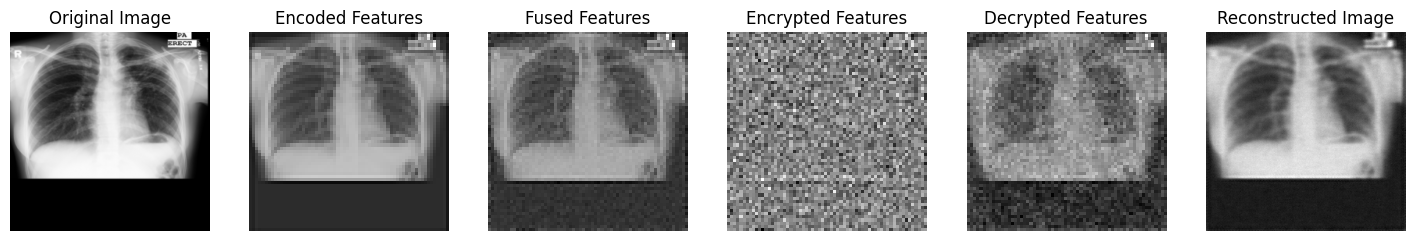

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a sample image from the dataset
sample_images = next(iter(dataloader))  # Only retrieve images
sample_image = sample_images[0].unsqueeze(0).to(device)  # Pick first image

# Forward pass through the model
encoded_features = encoder(sample_image)
feature_key = torch.randn_like(encoded_features).to(device)
fused_features = fusion_module(encoded_features, feature_key)
encrypted_key, encrypted_feature = encryption_module(feature_key, fused_features)
decrypted_key, decrypted_feature = decryption_module(encrypted_key, encrypted_feature)
reconstructed_image = decoder(decrypted_feature)

# Convert tensors to NumPy for visualization
def to_numpy(tensor):
    return tensor.squeeze().detach().cpu().numpy()

images = [
    to_numpy(sample_image),
    to_numpy(encoded_features.mean(dim=1)),  # Reduce channels
    to_numpy(fused_features.mean(dim=1)),
    to_numpy(encrypted_feature.mean(dim=1)),
    to_numpy(decrypted_feature.mean(dim=1)),
    to_numpy(reconstructed_image)
]
titles = ["Original Image", "Encoded Features", "Fused Features", "Encrypted Features", "Decrypted Features", "Reconstructed Image"]

# Display images
fig, axes = plt.subplots(1, 6, figsize=(18, 5))
for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')
plt.show()

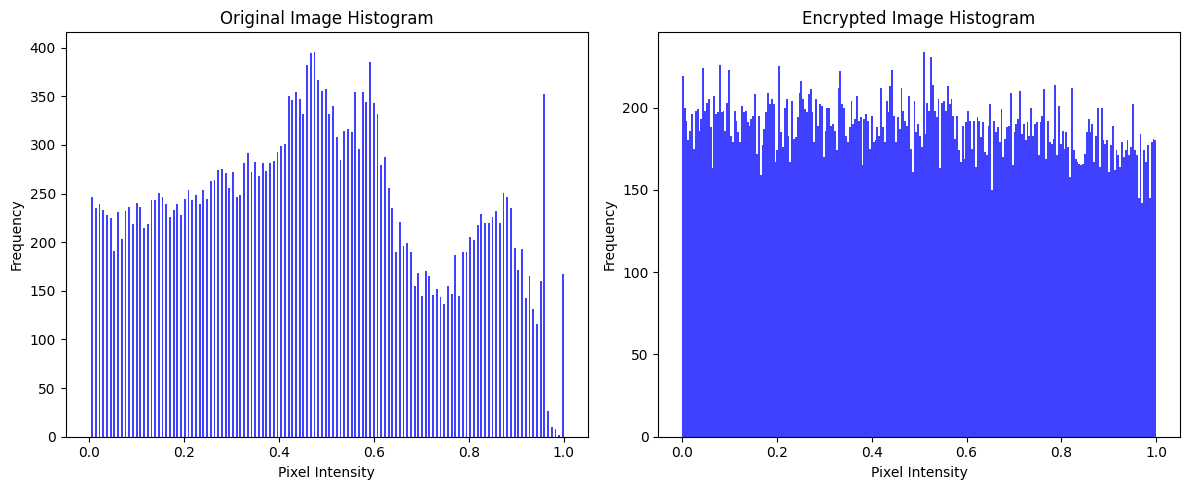

In [ ]:
import matplotlib.pyplot as plt

def plot_histograms(image_tensor1, title1, image_tensor2, title2):
    image_array1 = image_tensor1.detach().cpu().numpy().flatten()
    image_array2 = image_tensor2.detach().cpu().numpy().flatten()

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with 2 subplots

    axes[0].hist(image_array1, bins=256, range=(0, 1), alpha=0.75, color='blue')
    axes[0].set_title(title1)
    axes[0].set_xlabel("Pixel Intensity")
    axes[0].set_ylabel("Frequency")

    axes[1].hist(image_array2, bins=256, range=(0, 1), alpha=0.75, color='blue')
    axes[1].set_title(title2)
    axes[1].set_xlabel("Pixel Intensity")
    axes[1].set_ylabel("Frequency")

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Plot histograms side by side
plot_histograms(sample_image, "Original Image Histogram", encrypted_feature, "Encrypted Image Histogram")

In [ ]:
import scipy.stats as stats

def compute_correlation(image_tensor):
    image = to_numpy(image_tensor)
    x = image[:, :-1].flatten()  # Original pixels
    y = image[:, 1:].flatten()   # Neighboring pixels
    return stats.pearsonr(x, y)[0]  # Compute Pearson correlation

# Compute correlation for original and encrypted images
corr_original = compute_correlation(sample_image)
corr_encrypted = compute_correlation(encrypted_feature)

print(f"Pixel Correlation - Original Image: {corr_original:.4f}")
print(f"Pixel Correlation - Encrypted Image: {corr_encrypted:.4f}")


Pixel Correlation - Original Image: 0.9918
Pixel Correlation - Encrypted Image: 0.0238


In [ ]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

def compute_correlation(image_tensor, direction):
    """
    Computes Pearson correlation coefficient between adjacent pixels
    in the given direction (horizontal, vertical, diagonal).
    """
    image = image_tensor.squeeze().detach().cpu().numpy()  # Convert to numpy
    h, w = image.shape

    if direction == "horizontal":
        x = image[:, :-1].flatten()  # All pixels except last column
        y = image[:, 1:].flatten()   # All pixels except first column
    elif direction == "vertical":
        x = image[:-1, :].flatten()  # All pixels except last row
        y = image[1:, :].flatten()   # All pixels except first row
    elif direction == "diagonal":
        x = image[:-1, :-1].flatten()  # Top-left to bottom-right
        y = image[1:, 1:].flatten()    # One step diagonally

    return stats.pearsonr(x, y)[0]  # Compute Pearson correlation

# Compute correlation for original and encrypted images
directions = ["horizontal", "vertical", "diagonal"]
corr_values = {}

for direction in directions:
    corr_values[f"Original_{direction}"] = compute_correlation(sample_image, direction)
    corr_values[f"Encrypted_{direction}"] = compute_correlation(encrypted_feature.mean(dim=1), direction)

# Print results
for key, value in corr_values.items():
    print(f"{key} Correlation: {value:.4f}")


Original_horizontal Correlation: 0.9918
Encrypted_horizontal Correlation: 0.0091
Original_vertical Correlation: 0.9900
Encrypted_vertical Correlation: -0.0337
Original_diagonal Correlation: 0.9833
Encrypted_diagonal Correlation: 0.0231


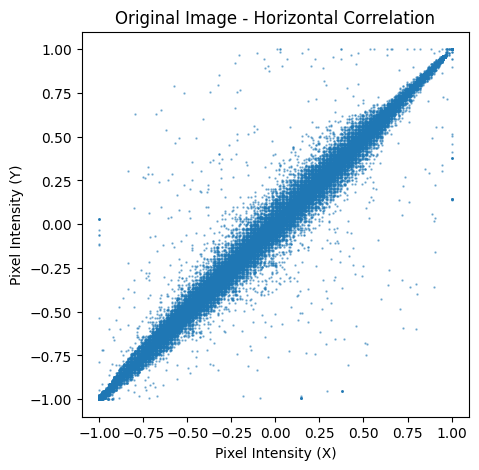

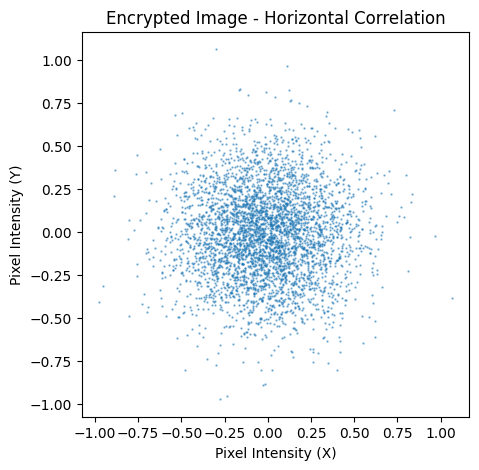

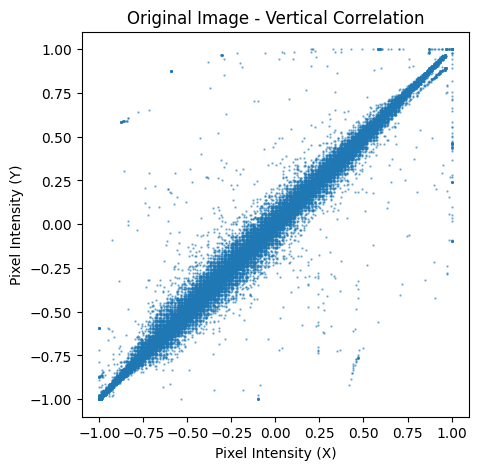

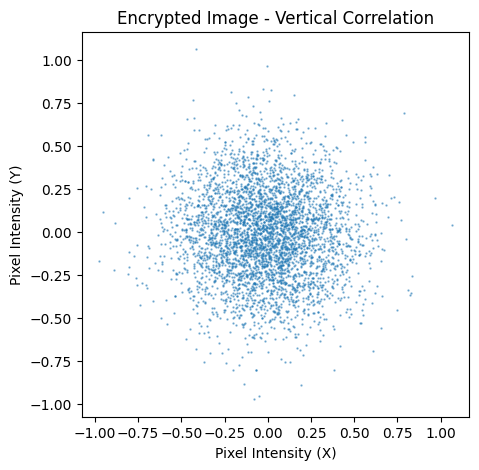

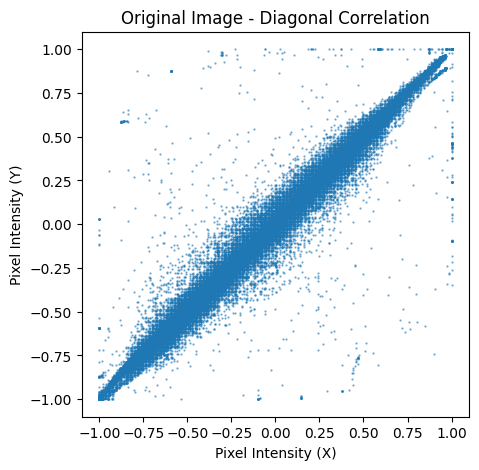

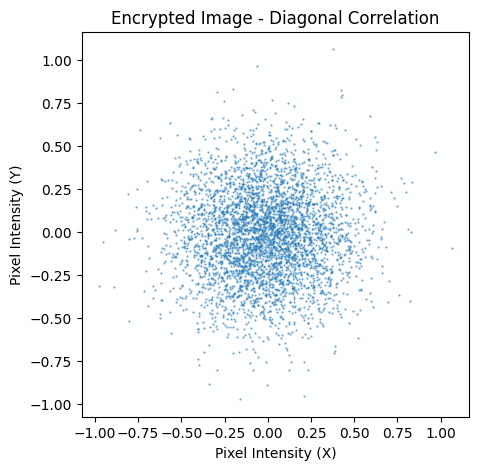

In [ ]:
def plot_scatter(image_tensor, direction, title):
    """
    Plots scatter plot of pixel intensities of adjacent pixels in the given direction.
    """
    image = image_tensor.squeeze().detach().cpu().numpy()

    if direction == "horizontal":
        x = image[:, :-1].flatten()
        y = image[:, 1:].flatten()
    elif direction == "vertical":
        x = image[:-1, :].flatten()
        y = image[1:, :].flatten()
    elif direction == "diagonal":
        x = image[:-1, :-1].flatten()
        y = image[1:, 1:].flatten()

    plt.figure(figsize=(5, 5))
    plt.scatter(x, y, s=0.5, alpha=0.5)  # Small dot size for clarity
    plt.xlabel("Pixel Intensity (X)")
    plt.ylabel("Pixel Intensity (Y)")
    plt.title(title)
    plt.show()

# Generate scatter plots
for direction in directions:
    plot_scatter(sample_image, direction, f"Original Image - {direction.capitalize()} Correlation")
    plot_scatter(encrypted_feature.mean(dim=1), direction, f"Encrypted Image - {direction.capitalize()} Correlation")


In [ ]:
perturbed_image = sample_image.clone()
perturbed_image[:, :, 128, 128] += 0.01  # Slightly change one pixel

# Forward pass for perturbed image
encoded_features_perturbed = encoder(perturbed_image)
fused_features_perturbed = fusion_module(encoded_features_perturbed, feature_key)
_, encrypted_feature_perturbed = encryption_module(feature_key, fused_features_perturbed)

# Compute pixel difference between encrypted and perturbed encrypted image
diff = torch.abs(encrypted_feature - encrypted_feature_perturbed).mean().item()
print(f"Diffusion Score (Higher is better): {diff:.6f}")

Diffusion Score (Higher is better): 0.000000


In [ ]:
def compute_entropy(image_tensor):
    image = to_numpy(image_tensor).flatten()
    hist, _ = np.histogram(image, bins=256, density=True)
    hist = hist[hist > 0]  # Avoid log(0)
    return -np.sum(hist * np.log2(hist))

entropy_original = compute_entropy(sample_image)
entropy_encrypted = compute_entropy(encrypted_feature)

print(f"Entropy - Original Image: {entropy_original:.4f}")
print(f"Entropy - Encrypted Image: {entropy_encrypted:.4f}")

Entropy - Original Image: 105.9281
Entropy - Encrypted Image: 42.7158
